In [1]:
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [2]:
import torch.nn as nn
import torch.nn.functional as F
# from torch.autograd import Variable
import torch
import numpy as np
import matplotlib.pyplot as plt
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

## Define net, training func given batch, and data. 

### Nets

In [ ]:
class GCN_SGD(torch.nn.Module):
    def __init__(self, H, use_bn = True):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(4, H))
        self.convs.append(GCNConv(H, H))
        self.convs.append(GCNConv(H, 3))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(H, affine = False))
        self.bns.append(torch.nn.BatchNorm1d(H, affine = False))
        self.use_bn = use_bn

    def forward(self, data):
        x, edge_index = data.x.to(device), data.edge_index.to(device)
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                if self.use_bn:
                    x = self.bns[i](x)
                x = F.relu(x)
            else:
                x = F.softmax(x, dim = 1)
        return x
    
        
    
class GCN_VI(nn.Module):
    def __init__(self, H, use_bn = True):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(4, H))
        self.convs.append(GCNConv(H, H))
        self.convs.append(GCNConv(H, 3))
        self.bns = torch.nn.ModuleList()
        self.bns.append(torch.nn.BatchNorm1d(H, affine = False))
        self.bns.append(torch.nn.BatchNorm1d(H, affine = False))
        self.use_bn = use_bn

        #### New lines for SVI ####
        # If any layer true, then it needs to use SVI
        self.layers_with_SVI = [True for i in range(len(self.convs))]
        # Append pre-activation \tilde{X}_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_Xtilde = []
        # Append the grad of L w.r.t. X_{l+1}, ONLY at layers i where self.layers_with_SVI[i] == True
        self.layers_grad = []
        self.on_training = True
        #### End #####

    #### New lines for SVI ####
    # Avoid gradient accumulation
    def turn_on_off_grad(self, on = True):
        for param in self.parameters():
            param.requires_grad = on
    #### End #####        

    def forward(self, data):
        x, edge_index = data.x.to(device), data.edge_index.to(device)
        for i, conv in enumerate(self.convs):
            #### New lines for SVI ####
            # This is added b/c o/w the gradient backprop w.r.t. new loss also gets to earlier layers (undesirable)
            if self.layers_with_SVI[i] and self.on_training:
                x_tmp = x.detach().clone().to(device)
                x_tmp = conv(x_tmp, edge_index)
                if i < len(self.convs) - 1 and self.use_bn:
                    x_tmp = self.bns[i](x_tmp)
                self.layers_Xtilde.append(x_tmp)
            #### End #####
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                if self.use_bn:
                    x = self.bns[i](x)
                x = F.relu(x)
            else:
                x = F.softmax(x, dim = 1)
            #### New lines for SVI ####
            if self.layers_with_SVI[i] and self.on_training:
                x.retain_grad()  # To get the gradient with respect to output
                self.layers_grad.append(x)
            #### End #####
        return x

def check_layer_grad(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(name, param.grad.norm())

def check_init_norm(model):
    print("#### Initial norm of parameters: ")
    for name, param in model.named_parameters():
        print(name, param.norm())

### For training

In [4]:
cost = nn.MSELoss()

def test(model, data):
    model.eval()
    out = model(data)
    label = F.one_hot(data.y.to(torch.int64), num_classes = 3).type(torch.FloatTensor).to(device)
    loss = cost(out, label) 
    return loss.item()

def train(model, data):
    model.train()
    # # Uncomment if want to debug
    # check_init_norm(model)
    out = model(data)
    label = F.one_hot(data.y.to(torch.int64), num_classes = 3).type(torch.FloatTensor).to(device)
    loss = cost(out, label)
    loss.backward()
    # # Uncomment if want to debug
    # print('#### Grad norm of SGD:')
    # check_layer_grad(model)
    # raise Exception("Stop here")
    return loss.item()

def train_SVI(model, data, small_prev_layer = False):
    model.train()
    # # Uncomment if want to debug
    # print(data.x.norm())
    # print(data.y.norm())
    # check_init_norm(model)
    #### New lines for SVI ####
    # NOTE: lines below are necessary, as o/w model.layers_x grow in size as epoches increases
    model.layers_Xtilde = []
    model.layers_grad = []
    model.on_training = True
    #### End #####
    out = model(data)
    label = F.one_hot(data.y.to(torch.int64), num_classes = 3).type(torch.FloatTensor).to(device)
    loss = cost(out, label) # MSE was \|x\|^2_2
    #### New lines for SVI #### 
    model.turn_on_off_grad(on = False) 
    #### End #####
    loss.backward() # By this time, model parameters should have no gradients
    # # Uncomment if want to debug
    # print(f'#### Grad norm before SVI')
    # check_layer_grad(model)
    #### New lines for SVI ####
    loss_tilde = 0
    k = 0
    for Xlplus1, Xlplus1grad in zip(model.layers_Xtilde, model.layers_grad):
        Xlplus1grad = Xlplus1grad.grad.detach().to(device)
        # This is correct, I have verified it on SVI_old to give the same results
        if small_prev_layer and k < len(model.layers_Xtilde) - 1:
            loss_tilde += (Xlplus1*Xlplus1grad).sum()/Xlplus1.shape[0]
        else:
            loss_tilde += (Xlplus1*Xlplus1grad).sum()
        k += 1
    # print([val.shape for val in model.layers_Xtilde])
    # raise Exception('Stop here')
    #####
    # ! This is because loss actually w.r.t. graph, NOT node, so need to multiply by # nodes
    num_nodes = int(data.x.shape[0]/data.num_graphs)
    loss_tilde = loss_tilde * num_nodes
    #####
    model.turn_on_off_grad(on = True)
    loss_tilde.backward()  # To get update direction by MVI for all layers at once
    # # Uncomment if want to debug
    # print(f'#### Grad norm after SVI')
    # check_layer_grad(model)
    # raise Exception("Stop here")
    model.on_training = False  # To avoid additional .retain_grad()
    #### End #####
    return loss.item()

In [5]:
# Regenerate data and train
def all_together(random_states, SGD = False, small_prev_layer = True):
    results_final_dict = {}
    for random_state in random_states:
        ##### Training
        torch.manual_seed(random_state)
        if SGD:
            model = GCN_SGD(H).to(device)
        else:
            model = GCN_VI(H).to(device)
        train_loss_all, test_loss_all = np.zeros(epochs), np.zeros(epochs)
        train_error_all, test_error_all = np.zeros(epochs), np.zeros(epochs)
        train_f1weight_all, test_f1weight_all = np.zeros(epochs), np.zeros(epochs)
        layer_1_norm_all, layer_2_norm_all, layer_3_norm_all = np.zeros(epochs), np.zeros(epochs), np.zeros(epochs)
        torch.manual_seed(random_state)
        dict_ref = copy.deepcopy(model.state_dict())
        for t in range(epochs):
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, 
                                    momentum=momen, nesterov=True)
            ### Train
            size = len(train_dataloader)
            train_loss = 0
            tot_num = 0
            for data in train_dataloader:
                optimizer.zero_grad()
                if SGD:
                    train_loss += train(model, data) * data.num_graphs
                else:
                    train_loss += train_SVI(model, data, small_prev_layer=small_prev_layer) * data.num_graphs
                tot_num += data.num_graphs
                optimizer.step()
            train_loss /= tot_num
            train_loss_all[t] = train_loss
            # Get prediction error w.r.t. true model
            train_error, train_f1weight = get_classification_error_and_f1(model, train_dataloader)
            train_error_all[t] = train_error
            train_f1weight_all[t] = train_f1weight

            ### Attach difference in parameter updates
            for name, param in model.named_parameters():
                if '0' in name:
                    layer_1_norm_all[t] += torch.norm(param - dict_ref[name])
                if '1' in name:
                    layer_2_norm_all[t] += torch.norm(param - dict_ref[name])
                if '2' in name:
                    layer_3_norm_all[t] += torch.norm(param - dict_ref[name])

            ### Test
            size = len(test_dataloader)
            test_loss = 0
            tot_num = 0 
            with torch.no_grad():
                model.eval()
                for data in test_dataloader:
                    test_loss += test(model, data) * data.num_graphs
                    tot_num += data.num_graphs
            test_loss /= tot_num
            test_loss_all[t] = test_loss
            # Get prediction error w.r.t. true model
            test_error, test_f1weight = get_classification_error_and_f1(model, test_dataloader)
            test_error_all[t] = test_error
            test_f1weight_all[t] = test_f1weight

        name = 'SGD' if SGD else 'SVI'
        suffix = ''
        if SGD == False:
            suffix = 'old' if small_prev_layer else 'new'
        print(f'{name} {suffix}, H={H}, random_state={random_state}')
        print(f'training loss = {train_loss_all[t]:.2e}, test loss = {test_loss_all[t]:.2e}')
        print(f'training error = {train_error_all[t]:.3f}, test error = {test_error_all[t]:.3f}')
        print(f'training f1weight = {train_f1weight_all[t]:.3f}, test f1weight = {test_f1weight_all[t]:.3f}')

        results = {'train_loss': train_loss_all, 
                    'test_loss': test_loss_all, 
                    'train_error': train_error_all,
                    'test_error': test_error_all,
                    'train_f1weight': train_f1weight_all,
                    'test_f1weight': test_f1weight_all,
                    'layer_1_norm': layer_1_norm_all,
                    'layer_2_norm': layer_2_norm_all,
                    'layer_3_norm': layer_3_norm_all}
        results['model'] = model.state_dict()
        results_final_dict[random_state] = results
    return results_final_dict, dict_ref, model

### For visualization

In [6]:
def get_ave_results(results_final_dict):
    keys = list(results_final_dict.keys())
    num_rep = len(keys)
    epochs = len(list(results_final_dict.values())[0]['train_loss'])
    ave_results, std_results = {}, {}
    std_suffix = '_std'
    for key in results_final_dict[keys[0]]:
        if key == 'model':
            continue
        ave_results[key] = np.zeros((num_rep, epochs))
        std_results[key+std_suffix] = np.zeros((num_rep, epochs))
    for i, random_state in enumerate(keys):
        for key in results_final_dict[random_state].keys():
            if key == 'model':
                continue
            ave_results[key][i] = results_final_dict[random_state][key]
            std_results[key+std_suffix][i] = results_final_dict[random_state][key]
    for key in ave_results.keys():
        ave_results[key] = np.mean(ave_results[key], axis = 0)
        std_results[key+std_suffix] = np.std(std_results[key+std_suffix], axis = 0)  
    final_dict = {}
    for key in ave_results.keys():
        final_dict[key] = ave_results[key]
        final_dict[key+std_suffix] = std_results[key+std_suffix] 
    return final_dict

In [7]:
def plot_on_axes(train_mean, train_std, test_mean, test_std, args):
    ax = args['ax']
    color = args['color']
    label = args['label']
    ax.plot(train_mean, color = color, label = label + ' train')
    ax.plot(test_mean, color = color, linestyle = '--', label = label + ' test')
    ax.fill_between(range(len(train_mean)), train_mean - train_std, train_mean + train_std, alpha = 0.2, color = color)
    ax.fill_between(range(len(test_mean)), test_mean - test_std, test_mean + test_std, alpha = 0.2, color = color)
    ax.legend()

def plot_on_axes_sub(mean, std, args):
    ax = args['ax']
    color = args['color']
    label = args['label']
    ax.plot(mean, color = color, label = label + ' train')
    ax.fill_between(range(len(mean)), mean - std, mean + std, alpha = 0.2, color = color)
    ax.legend()

### Data and eval functions

In [8]:
def get_traffic_train_test(num_neighbor=3, d=5):
    # Traffic flow multi-class detection
    import pickle
    with open(f'flow_frame_train_0.7_no_drop_data.p', 'rb') as fp:
        Xtrain = pickle.load(fp)
    with open(f'flow_frame_test_0.7_no_drop_data.p', 'rb') as fp:
        Xtest = pickle.load(fp)
    # # Standardize feature
    # from sklearn.preprocessing import StandardScaler
    # import pandas as pd
    # scaler = StandardScaler()
    # Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), columns=Xtrain.columns)
    # Xtest = pd.DataFrame(scaler.transform(Xtest), columns=Xtest.columns)
    with open(f'true_anomalies.p', 'rb') as fp:
        Yvals = pickle.load(fp)
    Ytrain = Yvals.iloc[:Xtrain.shape[0], :]
    Ytest = Yvals.iloc[Xtrain.shape[0]:, :]
    with open(f'sensor_neighbors.p', 'rb') as fp:
        neighbor_dict = pickle.load(fp)
    # Define edge index
    sensors = list(Xtrain.columns)
    sensors_dict = {i: j for (i, j) in zip(sensors, range(len(sensors)))}
    edge_index = []
    for k, sensor in enumerate(sensors):
        neighbors = neighbor_dict[sensor]
        for p in range(num_neighbor):
            edge_index.append([k, sensors_dict[neighbors[p]]])
    edge_index = torch.from_numpy(np.array(edge_index).T).type(torch.long)
    # Define graphs, similarly as the solar data
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []
    # d = 5
    for t in range(d, Xtrain.shape[0]):
        X_train.append(np.flip(Xtrain.iloc[t - d:t].to_numpy().T, 1))
        Y_train.append(Ytrain.iloc[t].to_numpy())
    for t in range(Xtest.shape[0]):
        if t < d:
            temp = np.c_[np.flip(Xtest.iloc[:t].to_numpy().T, 1),
                         np.flip(Xtrain.iloc[-(d - t):].to_numpy().T, 1)]
        else:
            temp = np.flip(Xtest.iloc[t - d:t].to_numpy().T, 1)
        X_test.append(temp)
        Y_test.append(Ytest.iloc[t].to_numpy())
    # # Randomly shuffle
    # X_full = X_train + X_test
    # Y_full = Y_train + Y_test
    # from sklearn.utils import shuffle
    # X_full, Y_full = shuffle(X_full, Y_full, random_state = 1103)
    # N_train = int(len(X_full) * 0.8)
    # X_train = X_full[:N_train]
    # X_test = X_full[N_train:]
    # Y_train = Y_full[:N_train]
    # Y_test = Y_full[N_train:]
    return [X_train, X_test, Y_train, Y_test, edge_index]

def get_train_test_loader(X_train, X_test, Y_train, Y_test, edge_index, batch_size):
    train_data_torch = []
    test_data_torch = []
    for Xtrain, Ytrain in zip(X_train, Y_train):
        train_temp = Data(x=torch.from_numpy(Xtrain.copy()).type(
            torch.float), edge_index=edge_index, y=torch.from_numpy(Ytrain).type(torch.float))
        train_data_torch.append(train_temp)
    for Xtest, Ytest in zip(X_test, Y_test):
        test_temp = Data(x=torch.from_numpy(Xtest.copy()).type(
            torch.float), edge_index=edge_index, y=torch.from_numpy(Ytest).type(torch.float))
        test_data_torch.append(test_temp)
    train_loader = DataLoader(train_data_torch, batch_size=batch_size)
    test_loader = DataLoader(test_data_torch, batch_size=batch_size)
    return [train_loader, test_loader]

In [9]:
# Other function
def get_classification_error_and_f1(model, data_loader):
    from sklearn.metrics import f1_score
    model.eval()
    correct_all = 0
    tot_num = 0
    tot_num1 = 0
    y_pred = []
    y_true = []
    # print(f'Output dimension is {output_dim}')
    for data in data_loader:
        data = data.to(device)
        output = model(data)
        pred_label = torch.argmax(output, dim=1)
        y_pred += pred_label.cpu().detach().numpy().tolist()
        label = data.y.type(torch.LongTensor).to(device)
        y_true += data.y.cpu().detach().numpy().tolist()
        correct_all += (pred_label.flatten() == data.y).sum().float()
        tot_num += len(label)
        tot_num1 += data.num_graphs
    errors = (1-correct_all/tot_num).item()
    f1weights = f1_score(y_true, y_pred, average='weighted')
    return errors, f1weights

In [10]:
n, num_neighbor, d = 20, 5, 4
N, batch_size  = 6138, 600
X_train, X_test, Y_train, Y_test, edge_index = get_traffic_train_test(num_neighbor, d)
fully_connected = False
print(len(X_train), len(X_test), len(Y_train), len(Y_test))
train_dataloader, test_dataloader = get_train_test_loader(X_train, X_test, Y_train, Y_test, edge_index, batch_size)

6139 2640 6139 2640


## 64-hidden nodes

In [11]:
# Hyperparameters
random_states = [1103, 1111, 1214] # This coupled with `Variable` for SGD would get the same results as in paper
H = 64

learning_rate = 0.001
momen = 0.99
epochs = 100

save = True
import pickle
savename = f'traffic_results_{H}_H.pkl'

### Training

In [12]:
# SGD
results_final_dict_SGD, SGD_dict_ref, model_SGD = all_together(random_states, SGD = True)

SGD , H=64, random_state=1103
training loss = 1.50e-01, test loss = 1.50e-01
training error = 0.333, test error = 0.335
training f1weight = 0.667, test f1weight = 0.665
SGD , H=64, random_state=1111
training loss = 1.49e-01, test loss = 1.50e-01
training error = 0.330, test error = 0.333
training f1weight = 0.669, test f1weight = 0.666
SGD , H=64, random_state=1214
training loss = 1.53e-01, test loss = 1.53e-01
training error = 0.342, test error = 0.348
training f1weight = 0.658, test f1weight = 0.651


In [13]:
# SVI old small scale
results_final_dict_SVI_old, VI_dict_ref_old, model_SVI_old = all_together(random_states, SGD = False,
                                          small_prev_layer = True)

SVI old, H=64, random_state=1103
training loss = 1.46e-01, test loss = 1.46e-01
training error = 0.328, test error = 0.331
training f1weight = 0.672, test f1weight = 0.669
SVI old, H=64, random_state=1111
training loss = 1.45e-01, test loss = 1.46e-01
training error = 0.330, test error = 0.334
training f1weight = 0.669, test f1weight = 0.666
SVI old, H=64, random_state=1214
training loss = 1.45e-01, test loss = 1.45e-01
training error = 0.329, test error = 0.333
training f1weight = 0.670, test f1weight = 0.666


In [14]:
# SVI new original scale
results_final_dict_SVI_new, VI_dict_ref, model_SVI = all_together(random_states, SGD = False,
                                          small_prev_layer = False)

SVI new, H=64, random_state=1103
training loss = 1.44e-01, test loss = 1.45e-01
training error = 0.328, test error = 0.327
training f1weight = 0.672, test f1weight = 0.673
SVI new, H=64, random_state=1111
training loss = 1.45e-01, test loss = 1.45e-01
training error = 0.327, test error = 0.330
training f1weight = 0.673, test f1weight = 0.670
SVI new, H=64, random_state=1214
training loss = 1.45e-01, test loss = 1.45e-01
training error = 0.327, test error = 0.331
training f1weight = 0.673, test f1weight = 0.669


In [ ]:
# Save
if save:
    file_to_save = {'SGD_results': results_final_dict_SGD,'SGD_dict_ref': SGD_dict_ref,
                    'SVI_old_results': results_final_dict_SVI_old,'SVI_old_dict_ref': VI_dict_ref_old,
                    'SVI_new_results': results_final_dict_SVI_new,'SVI_new_dict_ref': VI_dict_ref}
    with open(savename, 'wb') as f:
        pickle.dump(file_to_save, f)

### Save and/or Eval

In [12]:
# Load
load = True
import os
if os.path.exists(savename) and load:
    with open(savename, 'rb') as f:
        file_to_save = pickle.load(f)
    results_final_dict_SGD = file_to_save['SGD_results']
    SGD_dict_ref = file_to_save['SGD_dict_ref']
    results_final_dict_SVI_old = file_to_save['SVI_old_results']
    VI_dict_ref_old = file_to_save['SVI_old_dict_ref']
    results_final_dict_SVI_new = file_to_save['SVI_new_results']
    VI_dict_ref = file_to_save['SVI_new_dict_ref']

H = 64, by epoch 100 out of 100 epochs
####################
SGD train MSE loss mean: 0.15025816392906974 +/- 0.0016860077108350883
SGD test MSE loss mean: 0.15108357889182641 +/- 0.0014319486645953672
SVI_old train MSE loss mean: 0.14532794426948037 +/- 0.00016066695054927586
SVI_old test MSE loss mean: 0.14555480240872412 +/- 0.00018102457158570675
SVI train MSE loss mean: 0.1444862413148755 +/- 0.00016961226314205977
SVI test MSE loss mean: 0.14491753235007776 +/- 0.00018848315441457255
####################
SGD train classification error mean: 0.334655503431956 +/- 0.005027100472930562
SGD test classification error mean: 0.3386047879854838 +/- 0.006682046567796403
SVI_old train classification error mean: 0.3291116952896118 +/- 0.0011622479086568875
SVI_old test classification error mean: 0.33268938461939496 +/- 0.001319796215687302
SVI train classification error mean: 0.32728731632232666 +/- 0.00045123905132597833
SVI test classification error mean: 0.3289898832639058 +/- 0.001646776

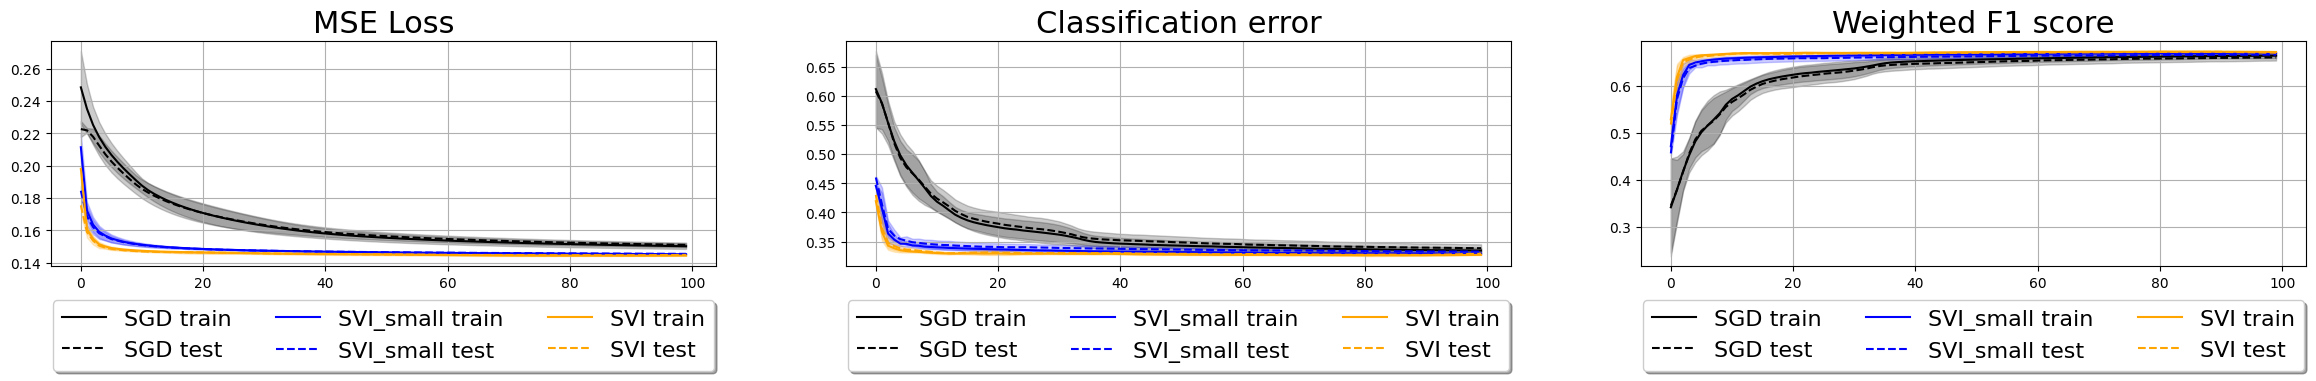

In [13]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = epochs
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train MSE loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SGD test MSE loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old train MSE loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI_old test MSE loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI train MSE loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print(f'SVI test MSE loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train classification error mean: {ave_results_SGD["train_error"][stop-1]} +/- {ave_results_SGD["train_error_std"][stop-1]}')
print(f'SGD test classification error mean: {ave_results_SGD["test_error"][stop-1]} +/- {ave_results_SGD["test_error_std"][stop-1]}')
print(f'SVI_old train classification error mean: {ave_results_SVI_old["train_error"][stop-1]} +/- {ave_results_SVI_old["train_error_std"][stop-1]}')
print(f'SVI_old test classification error mean: {ave_results_SVI_old["test_error"][stop-1]} +/- {ave_results_SVI_old["test_error_std"][stop-1]}')
print(f'SVI train classification error mean: {ave_results_SVI_new["train_error"][stop-1]} +/- {ave_results_SVI_new["train_error_std"][stop-1]}')
print(f'SVI test classification error mean: {ave_results_SVI_new["test_error"][stop-1]} +/- {ave_results_SVI_new["test_error_std"][stop-1]}')
print('####################')
print(f'SGD train F1 weighted mean: {ave_results_SGD["train_f1weight"][stop-1]} +/- {ave_results_SGD["train_f1weight_std"][stop-1]}')
print(f'SGD test F1 weighted mean: {ave_results_SGD["test_f1weight"][stop-1]} +/- {ave_results_SGD["test_f1weight_std"][stop-1]}')
print(f'SVI_old train F1 weighted mean: {ave_results_SVI_old["train_f1weight"][stop-1]} +/- {ave_results_SVI_old["train_f1weight_std"][stop-1]}')
print(f'SVI_old test F1 weighted mean: {ave_results_SVI_old["test_f1weight"][stop-1]} +/- {ave_results_SVI_old["test_f1weight_std"][stop-1]}')
print(f'SVI train F1 weighted mean: {ave_results_SVI_new["train_f1weight"][stop-1]} +/- {ave_results_SVI_new["train_f1weight_std"][stop-1]}')
print(f'SVI test F1 weighted mean: {ave_results_SVI_new["test_f1weight"][stop-1]} +/- {ave_results_SVI_new["test_f1weight_std"][stop-1]}')

fig, ax = plt.subplots(1, 3, figsize=(24, 4))
fsize = 22
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
args = {'ax': ax[0]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE Loss', fontsize=fsize)


args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_error', 'test_error', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)


args = {'ax': ax[2]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_f1weight', 'test_f1weight', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[2].set_title('Weighted F1 score', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()

H = 64, by epoch 20 out of 100 epochs
####################
SGD train MSE loss mean: 0.17186393052470628 +/- 0.005453046405014321
SGD test MSE loss mean: 0.171751686343641 +/- 0.006074040542317828
SVI_old train MSE loss mean: 0.14874062999510937 +/- 0.0004305285867827791
SVI_old test MSE loss mean: 0.14867161711057028 +/- 0.00024401472764876896
SVI train MSE loss mean: 0.14644012889557453 +/- 0.0005273751551694415
SVI test MSE loss mean: 0.14648175713690845 +/- 0.0007068536575141506
####################
SGD train classification error mean: 0.3765217065811157 +/- 0.01648758757382223
SGD test classification error mean: 0.3825063109397888 +/- 0.020029857364944042
SVI_old train classification error mean: 0.33676769336064655 +/- 0.00283667313342734
SVI_old test classification error mean: 0.34100379546483356 +/- 0.006225406035247622
SVI train classification error mean: 0.3296845555305481 +/- 0.00174967725779063
SVI test classification error mean: 0.3313888907432556 +/- 0.004341633286630648
##

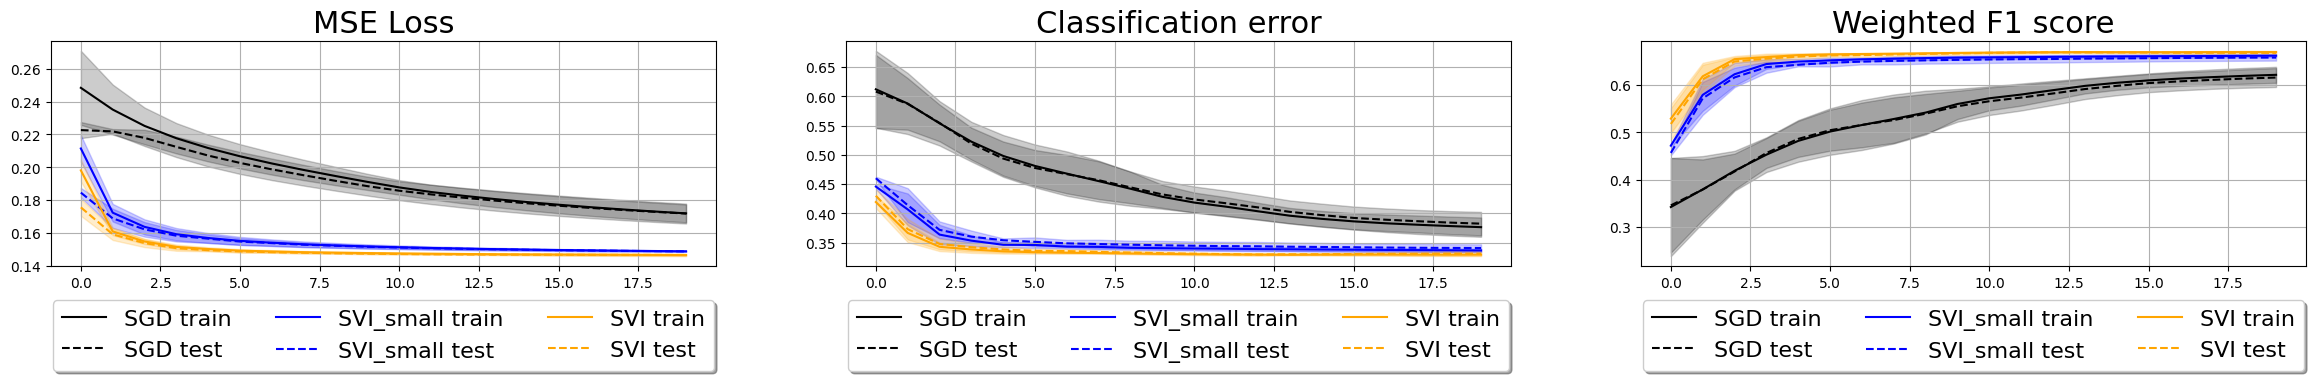

In [14]:
# Visualize results
ave_results_SGD = get_ave_results(results_final_dict_SGD)
ave_results_SVI_old = get_ave_results(results_final_dict_SVI_old)
ave_results_SVI_new = get_ave_results(results_final_dict_SVI_new)


# Plot losses and error
stop = 20
print(f'H = {H}, by epoch {stop} out of {epochs} epochs')
print('####################')
print(f'SGD train MSE loss mean: {ave_results_SGD["train_loss"][stop-1]} +/- {ave_results_SGD["train_loss_std"][stop-1]}')
print(f'SGD test MSE loss mean: {ave_results_SGD["test_loss"][stop-1]} +/- {ave_results_SGD["test_loss_std"][stop-1]}')
print(f'SVI_old train MSE loss mean: {ave_results_SVI_old["train_loss"][stop-1]} +/- {ave_results_SVI_old["train_loss_std"][stop-1]}')
print(f'SVI_old test MSE loss mean: {ave_results_SVI_old["test_loss"][stop-1]} +/- {ave_results_SVI_old["test_loss_std"][stop-1]}')
print(f'SVI train MSE loss mean: {ave_results_SVI_new["train_loss"][stop-1]} +/- {ave_results_SVI_new["train_loss_std"][stop-1]}')
print(f'SVI test MSE loss mean: {ave_results_SVI_new["test_loss"][stop-1]} +/- {ave_results_SVI_new["test_loss_std"][stop-1]}')
print('####################')
print(f'SGD train classification error mean: {ave_results_SGD["train_error"][stop-1]} +/- {ave_results_SGD["train_error_std"][stop-1]}')
print(f'SGD test classification error mean: {ave_results_SGD["test_error"][stop-1]} +/- {ave_results_SGD["test_error_std"][stop-1]}')
print(f'SVI_old train classification error mean: {ave_results_SVI_old["train_error"][stop-1]} +/- {ave_results_SVI_old["train_error_std"][stop-1]}')
print(f'SVI_old test classification error mean: {ave_results_SVI_old["test_error"][stop-1]} +/- {ave_results_SVI_old["test_error_std"][stop-1]}')
print(f'SVI train classification error mean: {ave_results_SVI_new["train_error"][stop-1]} +/- {ave_results_SVI_new["train_error_std"][stop-1]}')
print(f'SVI test classification error mean: {ave_results_SVI_new["test_error"][stop-1]} +/- {ave_results_SVI_new["test_error_std"][stop-1]}')
print('####################')
print(f'SGD train F1 weighted mean: {ave_results_SGD["train_f1weight"][stop-1]} +/- {ave_results_SGD["train_f1weight_std"][stop-1]}')
print(f'SGD test F1 weighted mean: {ave_results_SGD["test_f1weight"][stop-1]} +/- {ave_results_SGD["test_f1weight_std"][stop-1]}')
print(f'SVI_old train F1 weighted mean: {ave_results_SVI_old["train_f1weight"][stop-1]} +/- {ave_results_SVI_old["train_f1weight_std"][stop-1]}')
print(f'SVI_old test F1 weighted mean: {ave_results_SVI_old["test_f1weight"][stop-1]} +/- {ave_results_SVI_old["test_f1weight_std"][stop-1]}')
print(f'SVI train F1 weighted mean: {ave_results_SVI_new["train_f1weight"][stop-1]} +/- {ave_results_SVI_new["train_f1weight_std"][stop-1]}')
print(f'SVI test F1 weighted mean: {ave_results_SVI_new["test_f1weight"][stop-1]} +/- {ave_results_SVI_new["test_f1weight_std"][stop-1]}')

fig, ax = plt.subplots(1, 3, figsize=(24, 4))
fsize = 22
color_labels = {0: ['black', 'SGD'], 1: ['blue', 'SVI_small'], 2: ['orange', 'SVI']}
args = {'ax': ax[0]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_loss', 'test_loss', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[0].set_title('MSE Loss', fontsize=fsize)


args = {'ax': ax[1]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_error', 'test_error', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[1].set_title('Classification error', fontsize=fsize)


args = {'ax': ax[2]}
for i, ave_results in enumerate([ave_results_SGD, ave_results_SVI_old, ave_results_SVI_new]):
    train_key, test_key, suffix = 'train_f1weight', 'test_f1weight', '_std'
    args['color'], args['label'] = color_labels[i]
    plot_on_axes(ave_results[train_key][:stop], ave_results[train_key+suffix][:stop],
                 ave_results[test_key][:stop], ave_results[test_key+suffix][:stop],
                 args)
ax[2].set_title('Weighted F1 score', fontsize=fsize)

for a in ax.flatten():
    a.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                fancybox=True, shadow=True, ncol=3, fontsize=fsize-6)
    a.grid()
fig.tight_layout()
plt.show()